In [1]:
import os
import cv2
import numpy as np
import time
import yaml
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../PaddleOCR/')))
import tools.infer.utility as utility
from ppocr.utils.logging import get_logger
from tools.infer.utility import init_args, parse_args
from paddleocr import PaddleOCR, draw_ocr

from det_pred import TextDetector, mult2point, four_point_transform
from rec_pred import Paddlepreditor,yi_merge

In [2]:
det_config_path    = "../PaddleOCR/output/det1104/config.yml"
det_inference_path = '../PaddleOCR/output/det1104/inference'

rec_config_path   = "../PaddleOCR/output/rec1109/config.yml"
rec_pretrain_path = "../PaddleOCR/output/rec1109/best_accuracy"

In [3]:
det_args_init = init_args()
det_args, unknown = det_args_init.parse_known_args()

In [4]:
det_args.det_sast_score_thresh = 0.1
det_args.det_sast_nms_thresh   = 0.05
det_args.det_model_dir= det_inference_path

In [5]:
import paddle
paddle.set_device("gpu:1")

CUDAPlace(1)

## load model

In [6]:
text_detector = TextDetector(det_args,det_config_path)

In [7]:
ocr = PaddleOCR(lang="en",
                det_model_dir='../PaddleOCR/inference/det1027',
                det_algorithm='DB',
                det_db_box_thresh=0.03,
                det_db_unclip_ratio=2,
                version='PP-OCR',
                use_angle_cls=True,
                show_log=False,
               )

Namespace(benchmark=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/workspace/PaddleOCR/inference/csc_cls_mv3', cls_thresh=0.9, cpu_threads=10, det=True, det_algorithm='DB', det_db_box_thresh=0.03, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=2, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='/workspace/PaddleOCR/inference/csc_det_db_mv3', det_sast_nms_thresh=0.2, det_sast_polygon=False, det_sast_score_thresh=0.5, drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e_pgnet_mode='fast', e2e_pgnet_polygon=True, e2e_pgnet_score_thresh=0.5, e2e_pgnet_valid_set='totaltext', enable_mkldnn=False, gpu_mem=500, help='==SUPPRESS==', image_dir=None, ir_optim=True, label_list=['0', '180'], lang='en', layout_path_model='lp://PubLayNet/ppyolov2_r50vd_dcn_365e_publa

In [8]:
def padding_box(x1,x2,y1,y2,pad_size=0):
    points=np.array([[x1-pad_size,y1-pad_size],
                     [x2+pad_size,y1-pad_size],
                     [x2+pad_size,y2+pad_size],
                     [x1-pad_size,y2+pad_size]
                    ])
    return points

In [9]:
def det_check(img_path,model='DB'):
    img_array = cv2.imread(img_path)
    if model=='DB':
        points = ocr.ocr(img_array, det=1, cls=0, rec=0)
    else:
        points, _ = text_detector(img_array)
    plt.figure(figsize=(30, 20), dpi=50)
    plt.imshow(draw_ocr(img_array,points))
    plt.show()
    return points

def det_pred_v99(img_array,thres=0.85):
    #img_array = cv2.imread(img_path)
    der_res1 = ocr.ocr(img_array, det=1, cls=0, rec=0)
    der_res2, _ = text_detector(img_array)    
    cand_points = np.array(der_res1+der_res2.tolist())
    avail_points = []
    for points in cand_points:
        crop_sample = four_point_transform(img_array, points)
        new_name = f"./data/tmp1_fig/test03.jpg"
        cv2.imwrite(new_name,crop_sample)
        pred = rec_sol.image_pred(new_name)
        if pred[-1]>thres:
            avail_points.append(points.tolist())
    x1,x2,y1,y2 = np.array(mult2point(avail_points),dtype=int)
    return x1,x2,y1,y2

In [10]:
rec_sol = Paddlepreditor(rec_config_path,rec_pretrain_path)

[2021/11/15 14:03:58] root INFO: load pretrained model from ['/workspace/PaddleOCR/output/model1109/best_accuracy']


## pred

In [11]:
import gc
from pred_eval import valid_eval2
from itertools import combinations
from p_tqdm import p_map
from functools import partial

In [12]:
def single_pred(infer_img_path,pad_range,det_thres=0.8,methods='all',show=False):
    if methods=='all':
        methods = ['orig','force180','blur','sharpen','bright','contrast','contrast+bright','dilation']
    output = {}
    _id = infer_img_path.split('/')[-1].replace('.jpg','')
    img = cv2.imread(infer_img_path)
    point_range = det_pred_v99(img,det_thres)
    cand_res = {}
    if show:
        show_point = padding_box(*point_range,pad_size=0)
        show_img = four_point_transform(img, show_point)     
        plt.imshow(show_img)
        plt.show()
    
    for pad in pad_range:
        det_point = padding_box(*point_range,pad_size=pad)
        crop_img = four_point_transform(img, det_point) 
        new_name = f"./data/tmp1_fig/{_id}_process3.jpg"
        cv2.imwrite(new_name,crop_img)
        single_res = rec_sol.super_image_pred_1105(new_name,methods,show=0)
        cand_res.update({f"pad{pad}_{k}":v for k,v in single_res.items()})
    output[_id] = cand_res
    return output

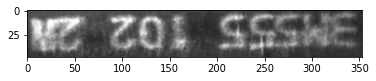

{'7hHbvk8KzK5hPUXoyDyOXYGSOz8hQN': {'pad0_orig': [('3M5551022W', 0.99655306)],
  'pad0_force180': [('3M5551022W', 0.99644315)],
  'pad0_blur': [('3M5551022W', 0.98182714)],
  'pad0_sharpen': [('3M5551022W', 0.9980499)],
  'pad0_bright': [('3M5551022W', 0.9782325)],
  'pad0_contrast': [('3M5551022W', 0.9782325)],
  'pad0_contrast+bright': [('3M5551022W', 0.9782325)],
  'pad0_dilation': [('3M5551022W', 0.992428)]}}

In [13]:
file1 = glob(f'./data/private_data/7hHbvk8KzK5hPUXoyDyOXYGSOz8hQN*')[0]

single_pred(file1,[0],show=True)

# improve

In [14]:
def det_pred_fix(img_array,thres=0.7,verbose=False,show=False):
    der_res1 = ocr.ocr(img_array, det=1, cls=0, rec=0)
    der_res2, _ = text_detector(img_array)    
    cand_points = np.array(der_res1+der_res2.tolist())
    avail_points = []
    for points in cand_points:
        crop_sample = four_point_transform(img_array, points)
        new_name = f"./data/tmp1_fig/test03.jpg"
        cv2.imwrite(new_name,crop_sample)
        pred = rec_sol.image_pred(new_name)
        if (pred[-1]>thres):
            avail_points.append(points.tolist())
            if show:
                plt.imshow(crop_sample)
                plt.show()
    ymin, ymax = 0,0
    
    for points in avail_points:
        cur_min, cur_max = min([x[1] for x in points]),max([x[1] for x in points])
        if cur_min>ymin: ymin=cur_min
        if cur_max>ymax: ymax=cur_max
    
    fix_points = []
    for points in avail_points:     
        cur_min, cur_max = min([x[1] for x in points]),max([x[1] for x in points])
        if (ymin<=cur_min<=ymax) or (ymin<=cur_max<=ymax):
            fix_points.append(points)
            
    x1,x2,y1,y2 = np.array(mult2point(fix_points),dtype=int)
    return x1,x2,y1,y2    

def single_pred_fix(infer_img_path,pad_range,thres=0.8,methods='all',show=False):
    if methods=='all':
        methods = ['orig','force180','blur','sharpen','bright','contrast','contrast+bright','dilation']
    output = {}
    _id = infer_img_path.split('/')[-1].replace('.jpg','')
    img = cv2.imread(infer_img_path)
    point_range = det_pred_fix(img,thres=thres)
    cand_res = {}
    if show:
        show_point = padding_box(*point_range,pad_size=0)
        show_img = four_point_transform(img, show_point)     
        plt.imshow(show_img)
        plt.show()
    
    for pad in pad_range:
        det_point = padding_box(*point_range,pad_size=pad)
        crop_img = four_point_transform(img, det_point) 
        new_name = f"./data/tmp1_fig/{_id}_process3.jpg"
        cv2.imwrite(new_name,crop_img)
        single_res = rec_sol.super_image_pred_1105(new_name,methods,show=0)
        cand_res.update({f"pad{pad}_{k}":v for k,v in single_res.items()})
    output[_id] = cand_res
    return output

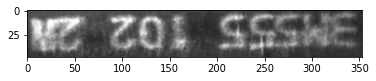

{'7hHbvk8KzK5hPUXoyDyOXYGSOz8hQN': {'pad0_orig': [('3M5551022W', 0.99655306)],
  'pad0_force180': [('3M5551022W', 0.99644315)],
  'pad0_blur': [('3M5551022W', 0.98182714)],
  'pad0_contrast': [('3M5551022W', 0.9782325)]}}

In [15]:
single_pred_fix(file1,[0],thres=0.65,methods=['orig','force180','blur','contrast'],show=1)